In [1]:
import os
import numpy as np

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from pathlib import Path

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import colors

import sys

from tqdm import tqdm

plt.rcParams["image.cmap"] = "jet"

In [2]:
#save model pth
save=True

# Setting path
path = Path("Y:/ptychosaxs")  # /net/micdata/data2/12IDC mounted windows drive
path = Path("/net/micdata/data2/12IDC/ptychosaxs/")
# Join paths
MODEL_SAVE_PATH = path / 'trained_model/' # Automatically adds the correct separator
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)
print(MODEL_SAVE_PATH)

/net/micdata/data2/12IDC/ptychosaxs/trained_model


In [3]:
# Load preprocessed data
num=30#17
numDPs=5000#10000

# Load the data once instead of three times
data_path = os.path.abspath(os.path.join(os.getcwd(), f'../../data/processed/preprocessed_dir{num}_numDPs{numDPs}.npz'))
data = np.load(data_path)

# Extract the arrays
amp_conv_red = data['amp_conv_red']
amp_ideal_red = data['amp_ideal_red']
amp_probe_red = data['amp_probe_red']

In [4]:
# Set the number of patterns in test, train or validation set
NTEST = amp_conv_red.shape[0]//4
NTRAIN = amp_conv_red.shape[0]-NTEST
NVALID = NTEST//2 # NTRAIN//

print(NTRAIN,NTEST,NVALID)

8100 2700 1350


In [5]:
EPOCHS = 256
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS*16
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

no_probe=True
H,W=amp_ideal_red[0].shape[0],amp_ideal_red[0].shape[1]
print(H,W)

GPUs: 2 Batch size: 32 Learning rate: 0.002
256 256


In [6]:
#separate data and convert to tensors and shuffle
no_probe=True

tst_start = amp_conv_red.shape[0]-NTEST

X_train = amp_conv_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = amp_conv_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Xp_train = amp_probe_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Xp_test = amp_probe_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Y_I_train = amp_ideal_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp_ideal_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain=X_train.shape[0]
ntest=X_test.shape[0]

X_train, Xp_train, Y_I_train = shuffle(X_train, Xp_train, Y_I_train, random_state=0)

#Training data
X_train_tensor = torch.Tensor(X_train)
Xp_train_tensor = torch.Tensor(Xp_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 

#Test data
X_test_tensor = torch.Tensor(X_test)
Xp_test_tensor = torch.Tensor(Xp_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 

print(X_train_tensor.shape,Xp_train_tensor.shape, Y_I_train_tensor.shape)


if no_probe:
    train_data = TensorDataset(X_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)
else:
    train_data = TensorDataset(X_train_tensor,Xp_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)


N_TRAIN = X_train_tensor.shape[0]

train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-NVALID,NVALID])
print(len(train_data2),len(train_data2[0]),len(valid_data),len(test_data))


#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

torch.Size([8100, 1, 256, 256]) torch.Size([8100, 1, 256, 256]) torch.Size([8100, 1, 256, 256])
6750 2 1350 2700


In [7]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src/models/'))) 
from encoder1 import recon_model

model = recon_model()
load_prev_model=True

In [8]:
if no_probe:
    for ampsI,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI)#,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break
else:
    for ampsI,ampsP,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    #model = nn.parallel.DistributedDataParallel(model) #Default all devices
    model = nn.DataParallel(model)

model = model.to(device)
print(model)

batch size: torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.float32
Let's use 2 GPUs!
DataParallel(
  (module): recon_model(
    (encoder1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder3): Sequential(
      (0): Co

In [9]:
#Optimizer details
iterations_per_epoch = np.floor((NTRAIN-NVALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 (6) number of iterations, step_size is half cycle
print(iterations_per_epoch)
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))



criterion = nn.L1Loss()
    

optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')
                                              
                                              
                                              #Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (NGPUS>1):    
        torch.save(model.module.state_dict(),path / 'best_model_ZCB_9.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model,path / 'best_model_ZCB_9.pth')

def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    
    for i, (ft_images,amps) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass
        
        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss = loss_a #Use equiweighted amps and phase

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i]) 

def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    for j, (ft_images,amps) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass

        val_loss_a = criterion(pred_amps,amps)
        val_loss = val_loss_a
    
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j])
  
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)



211.0
LR step size is: 1266.0 which is every 6 epochs


In [19]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}
for epoch in range (EPOCHS):
    
  #Set model to train mode
  model.train() 
  #Training loop
  train(trainloader,metrics)
    
  #Switch model to eval mode
  model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  print('Epoch: %d | Total  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
  print('Epoch: %d | Amp | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
  print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0])) 

211it [00:21,  9.74it/s]


Saving improved model after Val Loss improved from inf to 0.04033
Epoch: 0 | Total  | Train Loss: 0.03942 | Val Loss: 0.04033
Epoch: 0 | Amp | Train Loss: 0.03942 | Val Loss: 0.04033
Epoch: 0 | Ending LR: 0.000215 


211it [00:21,  9.66it/s]


Epoch: 1 | Total  | Train Loss: 0.03941 | Val Loss: 0.04040
Epoch: 1 | Amp | Train Loss: 0.03941 | Val Loss: 0.04040
Epoch: 1 | Ending LR: 0.000202 


211it [00:22,  9.57it/s]


Epoch: 2 | Total  | Train Loss: 0.03941 | Val Loss: 0.04072
Epoch: 2 | Amp | Train Loss: 0.03941 | Val Loss: 0.04072
Epoch: 2 | Ending LR: 0.000211 


211it [00:21,  9.61it/s]


Epoch: 3 | Total  | Train Loss: 0.03942 | Val Loss: 0.04091
Epoch: 3 | Amp | Train Loss: 0.03942 | Val Loss: 0.04091
Epoch: 3 | Ending LR: 0.000221 


211it [00:22,  9.43it/s]


Saving improved model after Val Loss improved from 0.04033 to 0.04029
Epoch: 4 | Total  | Train Loss: 0.03942 | Val Loss: 0.04029
Epoch: 4 | Amp | Train Loss: 0.03942 | Val Loss: 0.04029
Epoch: 4 | Ending LR: 0.000230 


211it [00:21,  9.62it/s]


Epoch: 5 | Total  | Train Loss: 0.03941 | Val Loss: 0.04101
Epoch: 5 | Amp | Train Loss: 0.03941 | Val Loss: 0.04101
Epoch: 5 | Ending LR: 0.000239 


211it [00:22,  9.48it/s]


Saving improved model after Val Loss improved from 0.04029 to 0.04027
Epoch: 6 | Total  | Train Loss: 0.03940 | Val Loss: 0.04027
Epoch: 6 | Amp | Train Loss: 0.03940 | Val Loss: 0.04027
Epoch: 6 | Ending LR: 0.000249 


211it [00:22,  9.43it/s]


Epoch: 7 | Total  | Train Loss: 0.03940 | Val Loss: 0.04036
Epoch: 7 | Amp | Train Loss: 0.03940 | Val Loss: 0.04036
Epoch: 7 | Ending LR: 0.000254 


211it [00:22,  9.51it/s]


Saving improved model after Val Loss improved from 0.04027 to 0.04021
Epoch: 8 | Total  | Train Loss: 0.03942 | Val Loss: 0.04021
Epoch: 8 | Amp | Train Loss: 0.03942 | Val Loss: 0.04021
Epoch: 8 | Ending LR: 0.000245 


211it [00:22,  9.58it/s]


Epoch: 9 | Total  | Train Loss: 0.03941 | Val Loss: 0.04041
Epoch: 9 | Amp | Train Loss: 0.03941 | Val Loss: 0.04041
Epoch: 9 | Ending LR: 0.000236 


211it [00:22,  9.54it/s]


Epoch: 10 | Total  | Train Loss: 0.03938 | Val Loss: 0.04032
Epoch: 10 | Amp | Train Loss: 0.03938 | Val Loss: 0.04032
Epoch: 10 | Ending LR: 0.000226 


211it [00:21,  9.60it/s]


Epoch: 11 | Total  | Train Loss: 0.03938 | Val Loss: 0.04058
Epoch: 11 | Amp | Train Loss: 0.03938 | Val Loss: 0.04058
Epoch: 11 | Ending LR: 0.000217 


211it [00:22,  9.46it/s]


Epoch: 12 | Total  | Train Loss: 0.03939 | Val Loss: 0.04033
Epoch: 12 | Amp | Train Loss: 0.03939 | Val Loss: 0.04033
Epoch: 12 | Ending LR: 0.000208 


211it [00:22,  9.54it/s]


Epoch: 13 | Total  | Train Loss: 0.03938 | Val Loss: 0.04040
Epoch: 13 | Amp | Train Loss: 0.03938 | Val Loss: 0.04040
Epoch: 13 | Ending LR: 0.000201 


211it [00:22,  9.44it/s]


Epoch: 14 | Total  | Train Loss: 0.03937 | Val Loss: 0.04035
Epoch: 14 | Amp | Train Loss: 0.03937 | Val Loss: 0.04035
Epoch: 14 | Ending LR: 0.000206 


211it [00:21,  9.60it/s]


Epoch: 15 | Total  | Train Loss: 0.03938 | Val Loss: 0.04056
Epoch: 15 | Amp | Train Loss: 0.03938 | Val Loss: 0.04056
Epoch: 15 | Ending LR: 0.000210 


211it [00:22,  9.56it/s]


Epoch: 16 | Total  | Train Loss: 0.03937 | Val Loss: 0.04034
Epoch: 16 | Amp | Train Loss: 0.03937 | Val Loss: 0.04034
Epoch: 16 | Ending LR: 0.000215 


211it [00:22,  9.49it/s]


Epoch: 17 | Total  | Train Loss: 0.03935 | Val Loss: 0.04034
Epoch: 17 | Amp | Train Loss: 0.03935 | Val Loss: 0.04034
Epoch: 17 | Ending LR: 0.000220 


211it [00:21,  9.61it/s]


Epoch: 18 | Total  | Train Loss: 0.03936 | Val Loss: 0.04024
Epoch: 18 | Amp | Train Loss: 0.03936 | Val Loss: 0.04024
Epoch: 18 | Ending LR: 0.000224 


211it [00:22,  9.55it/s]


Saving improved model after Val Loss improved from 0.04021 to 0.04020
Epoch: 19 | Total  | Train Loss: 0.03937 | Val Loss: 0.04020
Epoch: 19 | Amp | Train Loss: 0.03937 | Val Loss: 0.04020
Epoch: 19 | Ending LR: 0.000227 


211it [00:22,  9.55it/s]


Saving improved model after Val Loss improved from 0.04020 to 0.04015
Epoch: 20 | Total  | Train Loss: 0.03935 | Val Loss: 0.04015
Epoch: 20 | Amp | Train Loss: 0.03935 | Val Loss: 0.04015
Epoch: 20 | Ending LR: 0.000223 


211it [00:22,  9.43it/s]


Epoch: 21 | Total  | Train Loss: 0.03935 | Val Loss: 0.04059
Epoch: 21 | Amp | Train Loss: 0.03935 | Val Loss: 0.04059
Epoch: 21 | Ending LR: 0.000218 


211it [00:22,  9.54it/s]


Epoch: 22 | Total  | Train Loss: 0.03935 | Val Loss: 0.04075
Epoch: 22 | Amp | Train Loss: 0.03935 | Val Loss: 0.04075
Epoch: 22 | Ending LR: 0.000213 


211it [00:22,  9.53it/s]


Epoch: 23 | Total  | Train Loss: 0.03935 | Val Loss: 0.04045
Epoch: 23 | Amp | Train Loss: 0.03935 | Val Loss: 0.04045
Epoch: 23 | Ending LR: 0.000208 


211it [00:22,  9.44it/s]


Epoch: 24 | Total  | Train Loss: 0.03936 | Val Loss: 0.04035
Epoch: 24 | Amp | Train Loss: 0.03936 | Val Loss: 0.04035
Epoch: 24 | Ending LR: 0.000204 


211it [00:22,  9.54it/s]


Epoch: 25 | Total  | Train Loss: 0.03934 | Val Loss: 0.04016
Epoch: 25 | Amp | Train Loss: 0.03934 | Val Loss: 0.04016
Epoch: 25 | Ending LR: 0.000200 


211it [00:22,  9.45it/s]


Epoch: 26 | Total  | Train Loss: 0.03935 | Val Loss: 0.04023
Epoch: 26 | Amp | Train Loss: 0.03935 | Val Loss: 0.04023
Epoch: 26 | Ending LR: 0.000203 


211it [00:22,  9.54it/s]


Epoch: 27 | Total  | Train Loss: 0.03934 | Val Loss: 0.04046
Epoch: 27 | Amp | Train Loss: 0.03934 | Val Loss: 0.04046
Epoch: 27 | Ending LR: 0.000205 


211it [00:22,  9.55it/s]


Epoch: 28 | Total  | Train Loss: 0.03934 | Val Loss: 0.04025
Epoch: 28 | Amp | Train Loss: 0.03934 | Val Loss: 0.04025
Epoch: 28 | Ending LR: 0.000207 


211it [00:22,  9.49it/s]


Epoch: 29 | Total  | Train Loss: 0.03934 | Val Loss: 0.04119
Epoch: 29 | Amp | Train Loss: 0.03934 | Val Loss: 0.04119
Epoch: 29 | Ending LR: 0.000210 


211it [00:22,  9.53it/s]


Epoch: 30 | Total  | Train Loss: 0.03935 | Val Loss: 0.04025
Epoch: 30 | Amp | Train Loss: 0.03935 | Val Loss: 0.04025
Epoch: 30 | Ending LR: 0.000212 


211it [00:22,  9.58it/s]


Epoch: 31 | Total  | Train Loss: 0.03933 | Val Loss: 0.04044
Epoch: 31 | Amp | Train Loss: 0.03933 | Val Loss: 0.04044
Epoch: 31 | Ending LR: 0.000214 


211it [00:22,  9.41it/s]


Epoch: 32 | Total  | Train Loss: 0.03936 | Val Loss: 0.04039
Epoch: 32 | Amp | Train Loss: 0.03936 | Val Loss: 0.04039
Epoch: 32 | Ending LR: 0.000211 


211it [00:22,  9.46it/s]


Epoch: 33 | Total  | Train Loss: 0.03934 | Val Loss: 0.04030
Epoch: 33 | Amp | Train Loss: 0.03934 | Val Loss: 0.04030
Epoch: 33 | Ending LR: 0.000209 


211it [00:21,  9.60it/s]


Epoch: 34 | Total  | Train Loss: 0.03934 | Val Loss: 0.04018
Epoch: 34 | Amp | Train Loss: 0.03934 | Val Loss: 0.04018
Epoch: 34 | Ending LR: 0.000207 


211it [00:22,  9.58it/s]


Epoch: 35 | Total  | Train Loss: 0.03933 | Val Loss: 0.04028
Epoch: 35 | Amp | Train Loss: 0.03933 | Val Loss: 0.04028
Epoch: 35 | Ending LR: 0.000204 


211it [00:21,  9.60it/s]


Epoch: 36 | Total  | Train Loss: 0.03933 | Val Loss: 0.04027
Epoch: 36 | Amp | Train Loss: 0.03933 | Val Loss: 0.04027
Epoch: 36 | Ending LR: 0.000202 


211it [00:21,  9.61it/s]


Epoch: 37 | Total  | Train Loss: 0.03933 | Val Loss: 0.04031
Epoch: 37 | Amp | Train Loss: 0.03933 | Val Loss: 0.04031
Epoch: 37 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 38 | Total  | Train Loss: 0.03935 | Val Loss: 0.04041
Epoch: 38 | Amp | Train Loss: 0.03935 | Val Loss: 0.04041
Epoch: 38 | Ending LR: 0.000201 


211it [00:22,  9.57it/s]


Epoch: 39 | Total  | Train Loss: 0.03934 | Val Loss: 0.04047
Epoch: 39 | Amp | Train Loss: 0.03934 | Val Loss: 0.04047
Epoch: 39 | Ending LR: 0.000203 


211it [00:22,  9.47it/s]


Epoch: 40 | Total  | Train Loss: 0.03932 | Val Loss: 0.04049
Epoch: 40 | Amp | Train Loss: 0.03932 | Val Loss: 0.04049
Epoch: 40 | Ending LR: 0.000204 


211it [00:21,  9.62it/s]


Epoch: 41 | Total  | Train Loss: 0.03932 | Val Loss: 0.04070
Epoch: 41 | Amp | Train Loss: 0.03932 | Val Loss: 0.04070
Epoch: 41 | Ending LR: 0.000205 


211it [00:22,  9.38it/s]


Epoch: 42 | Total  | Train Loss: 0.03933 | Val Loss: 0.04034
Epoch: 42 | Amp | Train Loss: 0.03933 | Val Loss: 0.04034
Epoch: 42 | Ending LR: 0.000206 


211it [00:22,  9.52it/s]


Saving improved model after Val Loss improved from 0.04015 to 0.04013
Epoch: 43 | Total  | Train Loss: 0.03932 | Val Loss: 0.04013
Epoch: 43 | Amp | Train Loss: 0.03932 | Val Loss: 0.04013
Epoch: 43 | Ending LR: 0.000207 


211it [00:22,  9.53it/s]


Epoch: 44 | Total  | Train Loss: 0.03931 | Val Loss: 0.04038
Epoch: 44 | Amp | Train Loss: 0.03931 | Val Loss: 0.04038
Epoch: 44 | Ending LR: 0.000206 


211it [00:22,  9.56it/s]


Epoch: 45 | Total  | Train Loss: 0.03932 | Val Loss: 0.04028
Epoch: 45 | Amp | Train Loss: 0.03932 | Val Loss: 0.04028
Epoch: 45 | Ending LR: 0.000204 


211it [00:22,  9.49it/s]


Epoch: 46 | Total  | Train Loss: 0.03932 | Val Loss: 0.04037
Epoch: 46 | Amp | Train Loss: 0.03932 | Val Loss: 0.04037
Epoch: 46 | Ending LR: 0.000203 


211it [00:22,  9.55it/s]


Epoch: 47 | Total  | Train Loss: 0.03932 | Val Loss: 0.04031
Epoch: 47 | Amp | Train Loss: 0.03932 | Val Loss: 0.04031
Epoch: 47 | Ending LR: 0.000202 


211it [00:22,  9.54it/s]


Epoch: 48 | Total  | Train Loss: 0.03933 | Val Loss: 0.04027
Epoch: 48 | Amp | Train Loss: 0.03933 | Val Loss: 0.04027
Epoch: 48 | Ending LR: 0.000201 


211it [00:22,  9.59it/s]


Epoch: 49 | Total  | Train Loss: 0.03930 | Val Loss: 0.04022
Epoch: 49 | Amp | Train Loss: 0.03930 | Val Loss: 0.04022
Epoch: 49 | Ending LR: 0.000200 


211it [00:22,  9.42it/s]


Epoch: 50 | Total  | Train Loss: 0.03930 | Val Loss: 0.04126
Epoch: 50 | Amp | Train Loss: 0.03930 | Val Loss: 0.04126
Epoch: 50 | Ending LR: 0.000201 


211it [00:22,  9.57it/s]


Epoch: 51 | Total  | Train Loss: 0.03931 | Val Loss: 0.04025
Epoch: 51 | Amp | Train Loss: 0.03931 | Val Loss: 0.04025
Epoch: 51 | Ending LR: 0.000201 


211it [00:22,  9.48it/s]


Epoch: 52 | Total  | Train Loss: 0.03931 | Val Loss: 0.04033
Epoch: 52 | Amp | Train Loss: 0.03931 | Val Loss: 0.04033
Epoch: 52 | Ending LR: 0.000202 


211it [00:22,  9.49it/s]


Epoch: 53 | Total  | Train Loss: 0.03930 | Val Loss: 0.04014
Epoch: 53 | Amp | Train Loss: 0.03930 | Val Loss: 0.04014
Epoch: 53 | Ending LR: 0.000202 


211it [00:22,  9.43it/s]


Epoch: 54 | Total  | Train Loss: 0.03931 | Val Loss: 0.04067
Epoch: 54 | Amp | Train Loss: 0.03931 | Val Loss: 0.04067
Epoch: 54 | Ending LR: 0.000203 


211it [00:22,  9.57it/s]


Epoch: 55 | Total  | Train Loss: 0.03932 | Val Loss: 0.04046
Epoch: 55 | Amp | Train Loss: 0.03932 | Val Loss: 0.04046
Epoch: 55 | Ending LR: 0.000203 


211it [00:22,  9.50it/s]


Epoch: 56 | Total  | Train Loss: 0.03930 | Val Loss: 0.04035
Epoch: 56 | Amp | Train Loss: 0.03930 | Val Loss: 0.04035
Epoch: 56 | Ending LR: 0.000203 


211it [00:22,  9.52it/s]


Epoch: 57 | Total  | Train Loss: 0.03932 | Val Loss: 0.04019
Epoch: 57 | Amp | Train Loss: 0.03932 | Val Loss: 0.04019
Epoch: 57 | Ending LR: 0.000202 


211it [00:21,  9.60it/s]


Epoch: 58 | Total  | Train Loss: 0.03931 | Val Loss: 0.04032
Epoch: 58 | Amp | Train Loss: 0.03931 | Val Loss: 0.04032
Epoch: 58 | Ending LR: 0.000202 


211it [00:21,  9.66it/s]


Epoch: 59 | Total  | Train Loss: 0.03930 | Val Loss: 0.04029
Epoch: 59 | Amp | Train Loss: 0.03930 | Val Loss: 0.04029
Epoch: 59 | Ending LR: 0.000201 


211it [00:21,  9.66it/s]


Epoch: 60 | Total  | Train Loss: 0.03930 | Val Loss: 0.04056
Epoch: 60 | Amp | Train Loss: 0.03930 | Val Loss: 0.04056
Epoch: 60 | Ending LR: 0.000200 


211it [00:21,  9.62it/s]


Epoch: 61 | Total  | Train Loss: 0.03931 | Val Loss: 0.04026
Epoch: 61 | Amp | Train Loss: 0.03931 | Val Loss: 0.04026
Epoch: 61 | Ending LR: 0.000200 


211it [00:22,  9.44it/s]


Epoch: 62 | Total  | Train Loss: 0.03930 | Val Loss: 0.04048
Epoch: 62 | Amp | Train Loss: 0.03930 | Val Loss: 0.04048
Epoch: 62 | Ending LR: 0.000200 


211it [00:22,  9.36it/s]


Epoch: 63 | Total  | Train Loss: 0.03931 | Val Loss: 0.04034
Epoch: 63 | Amp | Train Loss: 0.03931 | Val Loss: 0.04034
Epoch: 63 | Ending LR: 0.000201 


211it [00:22,  9.58it/s]


Epoch: 64 | Total  | Train Loss: 0.03928 | Val Loss: 0.04016
Epoch: 64 | Amp | Train Loss: 0.03928 | Val Loss: 0.04016
Epoch: 64 | Ending LR: 0.000201 


211it [00:22,  9.46it/s]


Epoch: 65 | Total  | Train Loss: 0.03931 | Val Loss: 0.04019
Epoch: 65 | Amp | Train Loss: 0.03931 | Val Loss: 0.04019
Epoch: 65 | Ending LR: 0.000201 


211it [00:21,  9.64it/s]


Epoch: 66 | Total  | Train Loss: 0.03930 | Val Loss: 0.04015
Epoch: 66 | Amp | Train Loss: 0.03930 | Val Loss: 0.04015
Epoch: 66 | Ending LR: 0.000202 


48it [00:04,  9.65it/s]


KeyboardInterrupt: 

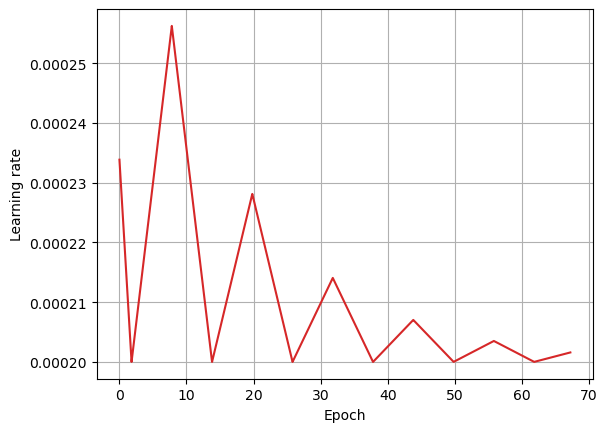

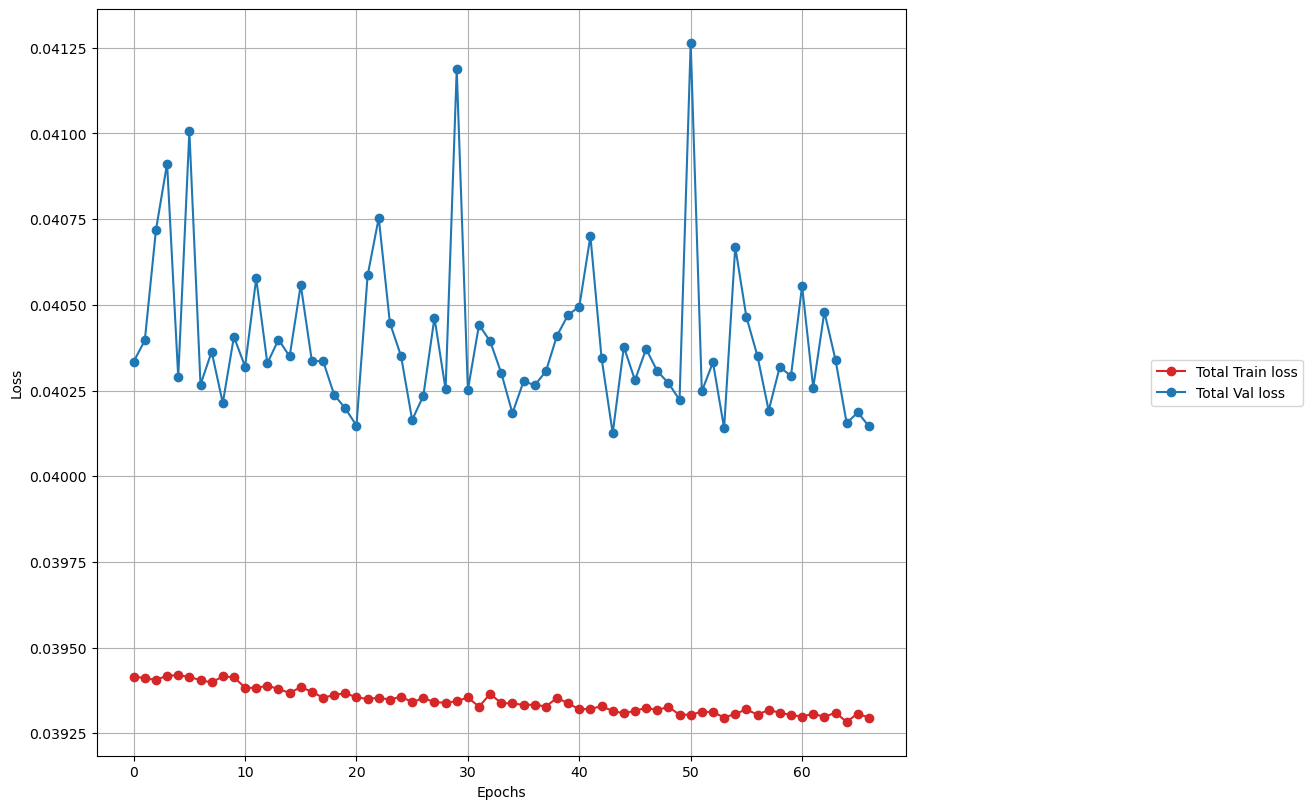

In [20]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")


losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(1,sharex=True, figsize=(15, 8))
ax.plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax.plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax.set(ylabel='Loss')
ax.grid()
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.xlabel("Epochs")
plt.show()

<Figure size 640x480 with 0 Axes>

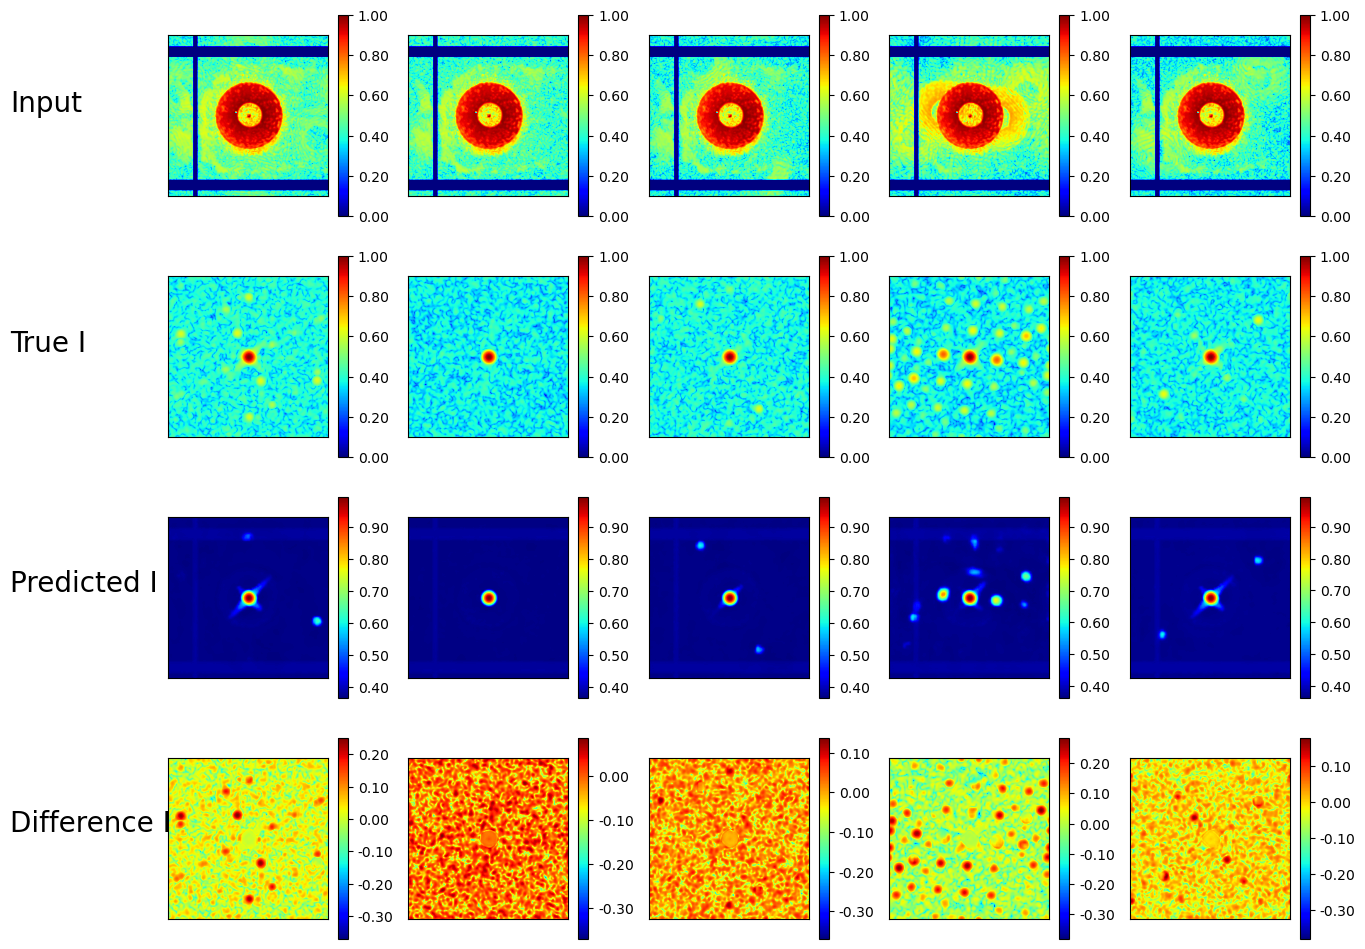

In [26]:
model.eval()
#model_new.eval() #imp when have dropout etc
results = []
for i, test in enumerate(testloader):
    tests = test[0].to(device)
    testsp = test[1].to(device)
    result = model(tests)
    for j in range(tests.shape[0]):
        results.append(result[j].detach().to("cpu").numpy())
        
results = np.array(results).squeeze()



h,w = H,W
ntest=results.shape[0]
plt.figure()
n = 5
f,ax=plt.subplots(4,n,figsize=(15, 12))
plt.gcf().text(0.02, 0.8, "Input", fontsize=20)
plt.gcf().text(0.02, 0.6, "True I", fontsize=20)
plt.gcf().text(0.02, 0.4, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.2, "Difference I", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display FT
    im=ax[0,i].imshow(X_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)

    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
plt.show()